# Convolution Neuron Networks

In this section, you implement a simple Convolution Neuron Network (CNN) via tensorflow. You will be playing with different architectures of the CNN and see how it affects the performance of the CNN. In order to finish this section, you don't need to read the documentation from tensorflow. If you are not familiar with it, we will set up all the background for you and all you need to do is to see different how architectural choice affect the performance of the CNN.

Let's start by importing the libaries and setting up the model parameters. In this Pset, you will be working with the MNIST data sets, which is a set of images of handwritten digits, 0-9, you will be using CNN to classify them. Each image is 28x28 pixels wide, in grayscale (no color).

By now, you should have all the required libararies installed on your VM by the TA. If you see errors from the box below, please contact TA for support

In [1]:
# Import MINST data
%matplotlib inline
import matplotlib.pyplot as plt
import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
import tensorflow as tf
import numpy as np

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


As noted above, the MNIST data sets consist of images of hantwritten digits. Here is an example:

Actual value: 0


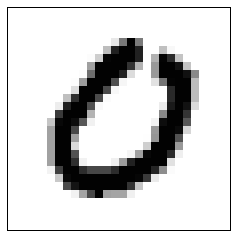

In [2]:
def display_minst_image(im):
    im_reshaped = im.reshape((28, 28))
    plt.imshow(im_reshaped, cmap='Greys', interpolation="nearest")
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    
def get_label_from_one_hot(onehot):
    return np.argmax(onehot)

# Show the 8th image (index 7) from the 
# training data set. There's also a validation training set
# to check performance after training.
display_minst_image(mnist.train.images[7])
print "Actual value: {}".format(get_label_from_one_hot(mnist.train.labels[7]))

First, we'll set up some parameters.

Below, the "dropout" is a technique to regulate the weights during the training to prevent the model overfitting. 

Tradiationlly, when solving an optimization problem, we use the Lagrangian multipliers and add them to the cost function. However, in the CNN, in practice, there are millions weights, therefore, in order to regulate the weights, at each layer, people randomly select a few number of neurons and "drop" them from the training to prevent overfiting.

In [3]:
# Parameters
learning_rate = 0.001
training_iters = 100000
# decsion the Batch size for the SGD algorithm
batch_size = 128
#how often do we show the output
display_step = 20
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

In [4]:
# tf Graph input. These "placeholders" will be filled later with the MNIST data set images and ground truth labels
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [5]:
#define covolution, ReLU layer and max pooling layer
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], 
                                                  padding='VALID'),b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

In the box below, we defined a CNN with 1 layer or convolution and 1 layer of max pool architecture for you. Please pay attention to how the variable is passed from "Apply Dropout" to the "Fully connected layer". Here you just need to run this code and later, we will ask to added one more convulition/ReLU layer and max pooling layer

In [6]:
def conv_net(_X, _weights, _biases, _dropout):
    # The input layer is a 28x28x1 volume (only one color channel - grayscale)
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 28, 28, 1])
    # Convolution Layer
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling) with a stride of k=3
    conv1 = max_pool(conv1, k=3)
    # Apply Dropout (doesn't change number of neurons)
    conv1 = tf.nn.dropout(conv1, _dropout)
    
    # Output volume of this first convolutional layer: 
    #    Input image 28x28, convolution size of 5x5 yields a 24x24 result (28-5+1)
    #    we are using 32 activation layers, yielding a resulting output volume after
    #    the conv2d of 24x24x32.
    #
    #    The max pooling layer with a 3x3 stride takes each 3x3 tile of the image
    #    and yields just a single pixel. So after applying this to each activation layer,
    #    we result in an 8x8x32 output volume.
    #
    #    The dropout above doesn't change the size of the volume, so we finally end up with
    #    a 8x8x32 output volume after the above convolution, maxpool, and dropout layer.

    # Later on, you'll add another convolutional layer here...
    
    
    
    # Next, we'll add a fully connected layer from each of these 8x8x32 neurons
    # to 1024 neurons.
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv1, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd1']), _biases['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Finally, 10 more neurons fully connected to each of these 1024 above 
    # for the final class prediction.
    # Output, class prediction
    out = tf.add(tf.matmul(dense1, _weights['out']), _biases['out'])
    return out


# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])), 
    # fully connected, 8*8*32 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([8*8*32, 1024])), 
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [7]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.initialize_all_variables()
saver = tf.train.Saver()

In [8]:
# Train the model and get the accuracy score
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        if step == 1:
            print "Training started:"
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"
    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:256], 
                                                             y: mnist.test.labels[:256], 
                                                             keep_prob: 1.})
    # Save the model as a file so we can restore it later.
    saver.save(sess, "/tmp/model_1.ckpt")

Training started:
Iter 2560, Minibatch Loss= 1059.654907, Training Accuracy= 0.31250
Iter 5120, Minibatch Loss= 322.638153, Training Accuracy= 0.67188
Iter 7680, Minibatch Loss= 352.124573, Training Accuracy= 0.67188
Iter 10240, Minibatch Loss= 139.672440, Training Accuracy= 0.84375
Iter 12800, Minibatch Loss= 319.293884, Training Accuracy= 0.74219
Iter 15360, Minibatch Loss= 128.335205, Training Accuracy= 0.86719
Iter 17920, Minibatch Loss= 94.453339, Training Accuracy= 0.88281
Iter 20480, Minibatch Loss= 97.702202, Training Accuracy= 0.89844
Iter 23040, Minibatch Loss= 100.652725, Training Accuracy= 0.90625
Iter 25600, Minibatch Loss= 125.347412, Training Accuracy= 0.88281
Iter 28160, Minibatch Loss= 108.642715, Training Accuracy= 0.86719
Iter 30720, Minibatch Loss= 93.762505, Training Accuracy= 0.89844
Iter 33280, Minibatch Loss= 131.000458, Training Accuracy= 0.89844
Iter 35840, Minibatch Loss= 45.606998, Training Accuracy= 0.94531
Iter 38400, Minibatch Loss= 29.121376, Training Ac

The above shows the "testing accuracy" on the validation data set! Below, we can visualize some of the results of running our trained CNN on a few of the digits in this validation set.

In [8]:
## Steve added this
pred_out = tf.argmax(pred, 1)

def show_validation_result(sess, i):
    # Get the prediction and actual label
    cnn_predicted_digit = sess.run(pred_out, feed_dict={x: np.array([mnist.validation.images[i]]), 
                                                        keep_prob: 1.})[0]
    actual_digit = get_label_from_one_hot(mnist.validation.labels[i])
    display_minst_image(mnist.validation.images[i])
    plt.title('Predicted: {}, Actual: {}'.format(cnn_predicted_digit, actual_digit), 
              color=('blue' if actual_digit == cnn_predicted_digit else 'red'))
    
def show_many_validation_results(model_filename):
    with tf.Session() as sess:
        # Load the stored model
        saver.restore(sess, model_filename)
        N = 6
        M = 12
        index = 1
        # Make lots of subplots
        plt.figure(figsize=(12, 24))
        for i in range(N):
            for j in range(M):
                plt.subplot(M, N, index)
                show_validation_result(sess, index)
                index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

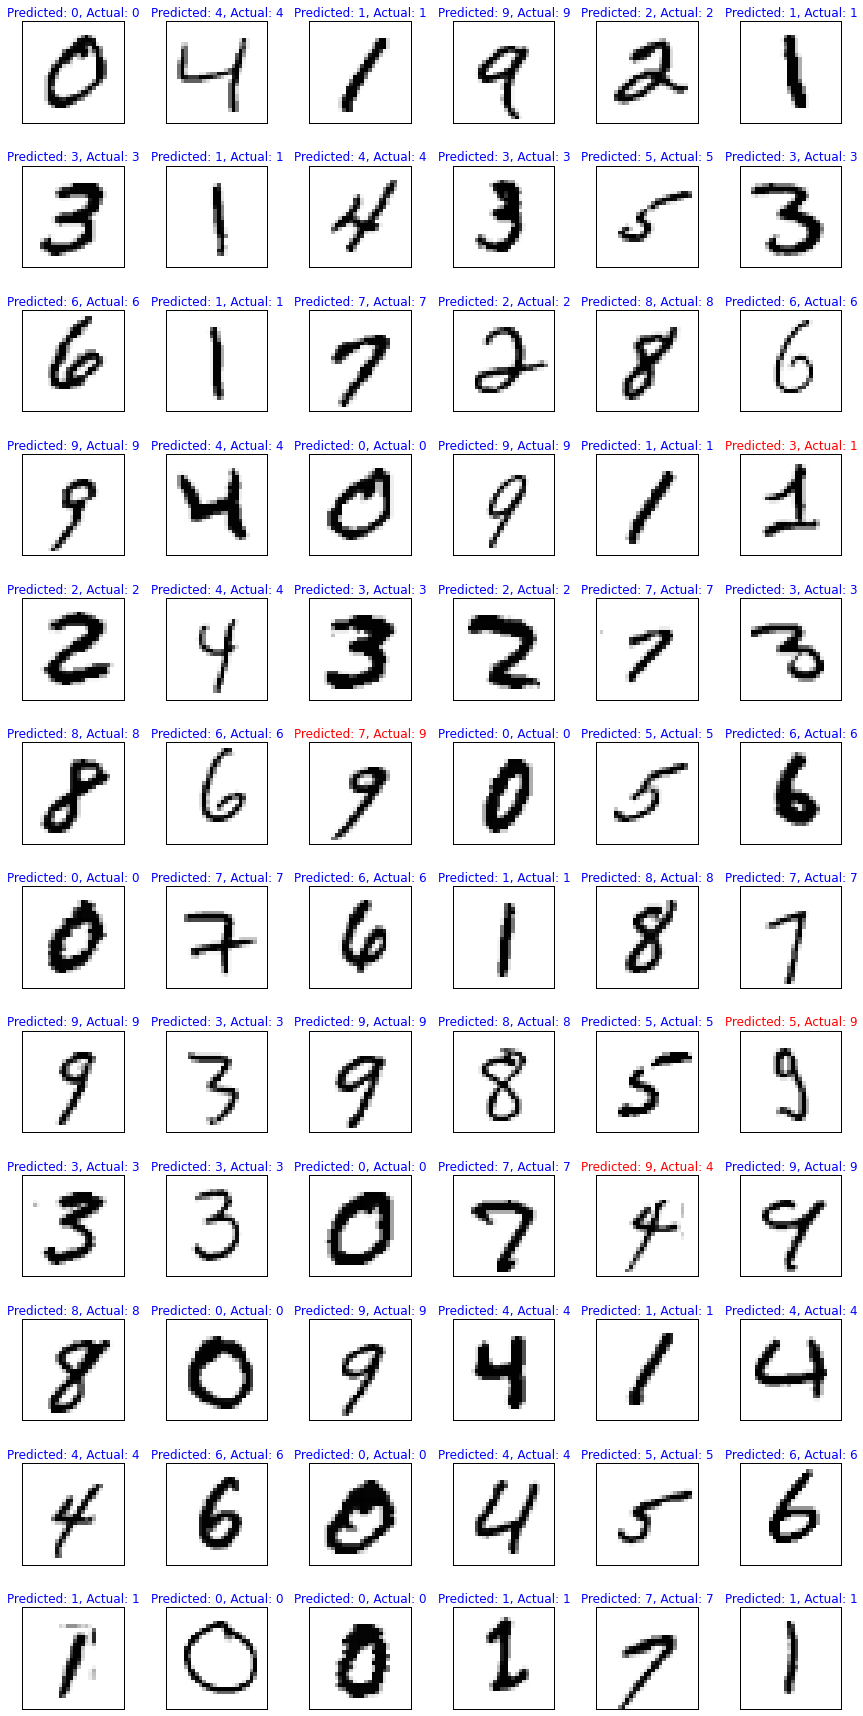

In [9]:
# Might take a few seconds to show up
show_many_validation_results("/tmp/model_1.ckpt")

# Your coding starts here

Now add one more convolution/ReLU layer and max pooling layer in the box below. Then run the flowing code to train your model again and compare the accucracy with the CNN with only 1 convolution/ReLU layer

<br/>
<div class="alert alert-warning">
<strong>Hint</strong>: you need to re-calculate the stride size based on the equation from the course slide
</div>

<br/>
<div class="alert alert-info">
Change the constant and implement the following function.
</div>

In [10]:
#define covolution, ReLU layer and max pooling layer
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [11]:
def conv_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 28, 28, 1])

    # Input: 28x28x1 volume
    
    # Convolution Layer 1
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    
    # Here: 28x28x32 volume (because of padding in conv2d above, padding='SAME')
    
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1, k=2)## You need to re-cacluate the stride here, which is value of k
    
    # Here: 14x14x32 volume
    
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)

    # Here: 14x14x32 volume
    
    ## YOUR CODE HERE
    # Convolution Layer 2
    conv2 = conv2d(conv1, _weights['wc2'], _biases['bc2'])
    
    # Here: 14x14x64 volume (again, because of padding)
    
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2, k=2)
    
    # Here: 7x7x64 volume
    
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)
    
    # Here: 7x7x64 volume
    
    #raise NotImplementedError("Whoops, forgot to add another layer")
    

    
    # Fully connected layer
    # Reshape conv1 output to fit dense layer input
    ## remember to change your input
    dense1 = tf.reshape(conv2, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd1']), _biases['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, _weights['out']), _biases['out'])
    return out

Since you add one more layer, then you will need to change the number of weights.

<br/>
<div class="alert alert-warning">
<strong>Hint</strong>: you will need to add weights and bias for the new layer
</div>

In [12]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # YOUR CODE HERE: Add weights for 'wc2':
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),  
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])), 
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    # YOUR CODE HERE: Add weights for 'bc2':
    
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# You don't need to edit the following code, just run it

In [13]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.initialize_all_variables()

In [14]:
# Train the model and get the accuracy score
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"
    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:256], 
                                                             y: mnist.test.labels[:256], 
                                                             keep_prob: 1.})
    # Save the model as a file so we can restore it later.
    saver.save(sess, "/tmp/model_2.ckpt")

Iter 2560, Minibatch Loss= 15401.458984, Training Accuracy= 0.41406
Iter 5120, Minibatch Loss= 8831.285156, Training Accuracy= 0.51562
Iter 7680, Minibatch Loss= 8079.928711, Training Accuracy= 0.68750
Iter 10240, Minibatch Loss= 4168.008789, Training Accuracy= 0.77344
Iter 12800, Minibatch Loss= 5268.761719, Training Accuracy= 0.68750
Iter 15360, Minibatch Loss= 2334.283936, Training Accuracy= 0.82812
Iter 17920, Minibatch Loss= 1733.804321, Training Accuracy= 0.83594
Iter 20480, Minibatch Loss= 1974.169067, Training Accuracy= 0.80469
Iter 23040, Minibatch Loss= 1812.914795, Training Accuracy= 0.82812
Iter 25600, Minibatch Loss= 2139.872803, Training Accuracy= 0.79688
Iter 28160, Minibatch Loss= 1474.436646, Training Accuracy= 0.83594
Iter 30720, Minibatch Loss= 1505.679199, Training Accuracy= 0.85156
Iter 33280, Minibatch Loss= 1339.453369, Training Accuracy= 0.88281
Iter 35840, Minibatch Loss= 863.780090, Training Accuracy= 0.89062
Iter 38400, Minibatch Loss= 837.489014, Training Ac

Now let's visualize these results:

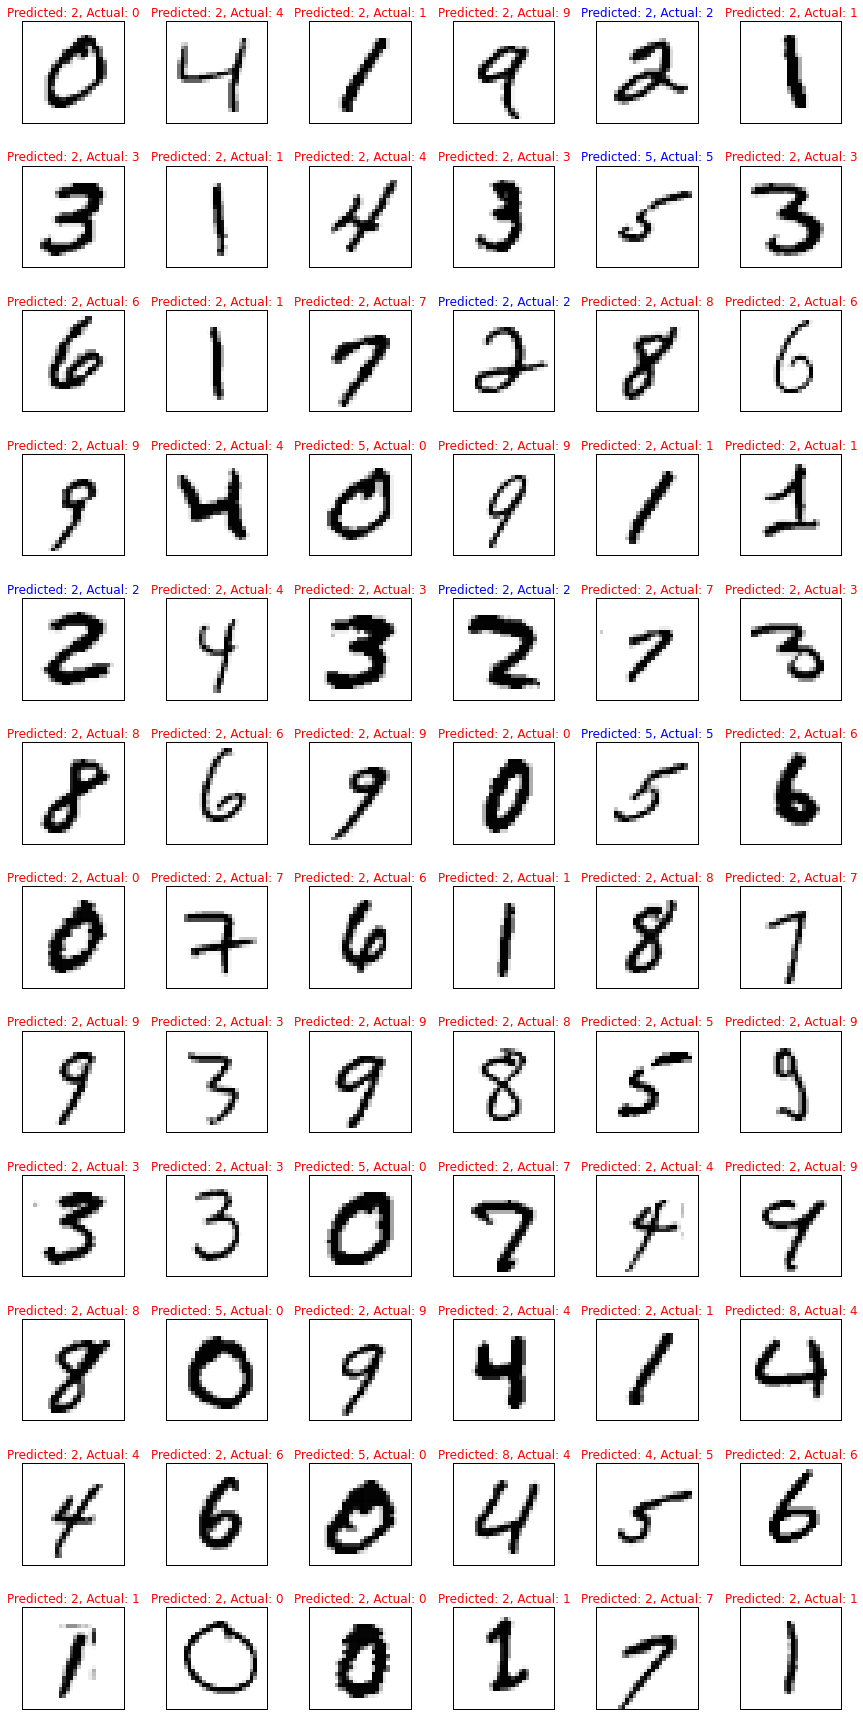

In [15]:
# Might take a few seconds to show up
show_many_validation_results("/tmp/model_2.ckpt")

Describe your findings below!

<br/>
<div class="alert alert-info">
Please describe your findings in the box below.
</div>

Your findings here...